In [2]:
from itertools import product
from pathlib import Path
import random
import string
import time
from typing import Optional
import psutil
import copy
import datetime


from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units
import tqdm
import polars as pl
from tqdm.notebook import tqdm as tqdm_notebook

from centrex_tlf import states, couplings, utils
from state_prep.utils import calculate_transition_frequency
from state_prep.electric_fields import (
    ElectricField,
    E_field_ring,
    Ez_from_csv,
    Ez_from_csv_offset,
)
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.intensity_profiles import GaussianBeam, MeasuredBeam, BackgroundField
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, Intensity, MicrowaveField
from state_prep.plotters import CouplingPlotter
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state


In [3]:
plt.rcParams.update({"font.size": 14})


In [4]:
cwd = Path().cwd().absolute()
path_data = cwd / "results"

In [5]:
nr_cores = psutil.cpu_count(logical=False)

rng = np.random.default_rng()

# Setup
## Constants

In [6]:
mu_fwhm = (1 * units.imperial.inch).si
v_forward = 184 * units.m / units.s
v_foward_sigma = 16 * units.m / units.s

z_start, z_stop = -75 * units.mm, 200 * units.mm

Bz = 1e-4 * units.Tesla

z_J12 = (1 * units.imperial.inch * 1.125).si
pos_J01 = np.array([0.0, 0.0, 0.0]) * units.m
pos_J12 = np.array([0.0, 0.0, z_J12.si.value]) * units.m


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [7]:
trajectory = Trajectory(
    Rini=np.array((0, 0, z_start.si.value)),
    Vini=np.array((0, 0, v_forward.si.value)),
    zfin=z_stop.si.value,
)


## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [8]:
Ez = Ez_from_csv()
E_R = lambda R: np.array([0, 0, Ez(R[2])])

electric_field = ElectricField(E_R, trajectory.R_t)


Max electric field: 263.47 V/cm
Electric field at z = 0: 172.39 V/cm


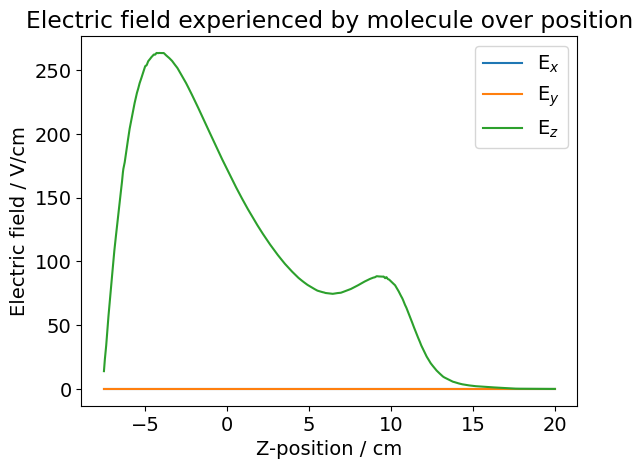

In [9]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position=True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 0: {E_R(np.array([0, 0, 0]))[2]:.2f} V/cm")


## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [10]:
B = np.array((0, 0, Bz.si.value))


def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3, 1)) * np.ones(R.shape)


magnetic_field = MagneticField(B_R, R_t=trajectory.R_t)


## Initial and final states
Define approximate initial states here.

In [11]:
# Define some useful approximate states
J0_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J0_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J0_triplet_p = 1 * states.UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=+1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J0_triplet_m = 1 * states.UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=+1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]


In [12]:
# Define some useful approximate states
J1_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J1_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J1_triplet_p = 1 * states.UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J1_triplet_m = 1 * states.UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J1_ppp = 1 * states.UncoupledBasisState(
    J=1,
    mJ=1,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J1_pmp = 1 * states.UncoupledBasisState(
    J=1,
    mJ=1,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)


# final_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]


In [13]:
J2_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J2_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J2_triplet_p = 1 * states.UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J2_triplet_m = 1 * states.UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

final_states_approx = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]


In [14]:
J3_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=3,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=3,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J3_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=3,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=3,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J3_triplet_p = 1 * states.UncoupledBasisState(
    J=3,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J3_triplet_m = 1 * states.UncoupledBasisState(
    J=3,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [15]:
Js = [0, 1, 2, 3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)


## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

In [16]:
# Define a function that gives the main component of the polarization as a function of position
p_main = couplings.polarization_Z
P_R = lambda R: p_main.vector

# Define k-vector
k = np.array((1, 0, 0))

pol = Polarization(P_R, k, f_long=1)

p_bg = (couplings.polarization_Z + (0.4 * couplings.polarization_Y)).normalize()
P_bg_R = lambda R: p_bg.vector
pol_background = Polarization(P_bg_R)


## Microwave frequencies

In [17]:
freq_01 = calculate_transition_frequency(
    J0_singlet, J1_singlet, hamiltonian.H_R(pos_J01.value), hamiltonian.QN
)
freq_12 = calculate_transition_frequency(
    J1_singlet, J2_singlet, hamiltonian.H_R(pos_J12.value), hamiltonian.QN
)
freq_12_rc_bg = calculate_transition_frequency(
    J1_singlet,
    J2_singlet,
    hamiltonian.H_R(np.array([0.0, 0.0, z_start.si.value])),
    hamiltonian.QN,
)
freq_23_rc_bg = calculate_transition_frequency(
    J2_singlet,
    J3_singlet,
    hamiltonian.H_R(np.array([0.0, 0.0, z_start.si.value])),
    hamiltonian.QN,
)

print(f"J01 transition frequency at center of microwaves: {freq_01 / 1e9:.5f} GHz")
print(f"J12 transition frequency at center of microwaves: {freq_12 / 1e9:.5f} GHz")
print(f"J12 RC bg frequency at center of microwaves: {freq_12_rc_bg / 1e9:.5f} GHz")
print(f"J23 RC bg frequency at center of microwaves: {freq_23_rc_bg / 1e9:.5f} GHz")

J01 transition frequency at center of microwaves: 13.34005 GHz
J12 transition frequency at center of microwaves: 26.66877 GHz
J12 RC bg frequency at center of microwaves: 26.66937 GHz
J23 RC bg frequency at center of microwaves: 40.00404 GHz


## Microwave fields
### Main coupling

In [18]:
lims = [
    (-1, 1),
    (-1, 1),
    (-1, 1),
]

intensity_01 = GaussianBeam(
    power=2e-4,
    sigma=utils.rabi.fwhm_to_sigma(mu_fwhm.si.value),
    R0=pos_J01.value,
    k=k,
    freq=freq_01,
)
intensity_12 = GaussianBeam(
    power=5e-5,
    sigma=utils.rabi.fwhm_to_sigma(mu_fwhm.si.value),
    R0=pos_J12.value,
    k=k,
    freq=freq_12,
)

mf01 = MicrowaveField(0, 1, intensity_01, pol, freq_01, hamiltonian.QN)
mf12 = MicrowaveField(1, 2, intensity_12, pol, freq_12, hamiltonian.QN)


### Background fields

In [19]:
intensity_01_bg = BackgroundField(
    lims, intensity=mf01.intensity.I_R(pos_J01.value) / 100
)
intensity_12_bg = BackgroundField(
    lims, intensity=mf12.intensity.I_R(pos_J12.value) / 100
)
intensity_bg_rc_12 = BackgroundField(lims, intensity=1e-3)
intensity_bg_rc_23 = BackgroundField(lims, intensity=1e-3)

mf01_bg = MicrowaveField(
    0,
    1,
    intensity_01_bg,
    pol_background,
    freq_01,
    hamiltonian.QN,
    background_field=True,
)

mf12_bg = MicrowaveField(
    1,
    2,
    intensity_12_bg,
    pol_background,
    freq_12,
    hamiltonian.QN,
    background_field=True,
)

mf12_rc_bg = MicrowaveField(
    1,
    2,
    intensity_bg_rc_12,
    pol_background,
    freq_12_rc_bg,
    hamiltonian.QN,
    background_field=True,
)

mf23_rc_bg = MicrowaveField(
    2,
    3,
    intensity_bg_rc_23,
    pol_background,
    freq_23_rc_bg,
    hamiltonian.QN,
    background_field=True,
)


In [31]:
microwave_fields = [mf01, mf12, mf01_bg, mf12_bg, mf23_rc_bg]

In [32]:
simulator = Simulator(
    trajectory,
    electric_field,
    magnetic_field,
    initial_states_approx,
    hamiltonian,
    microwave_fields,
)


In [33]:
result = simulator.run(N_steps=10_000)

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [00:40<00:00, 244.96it/s]


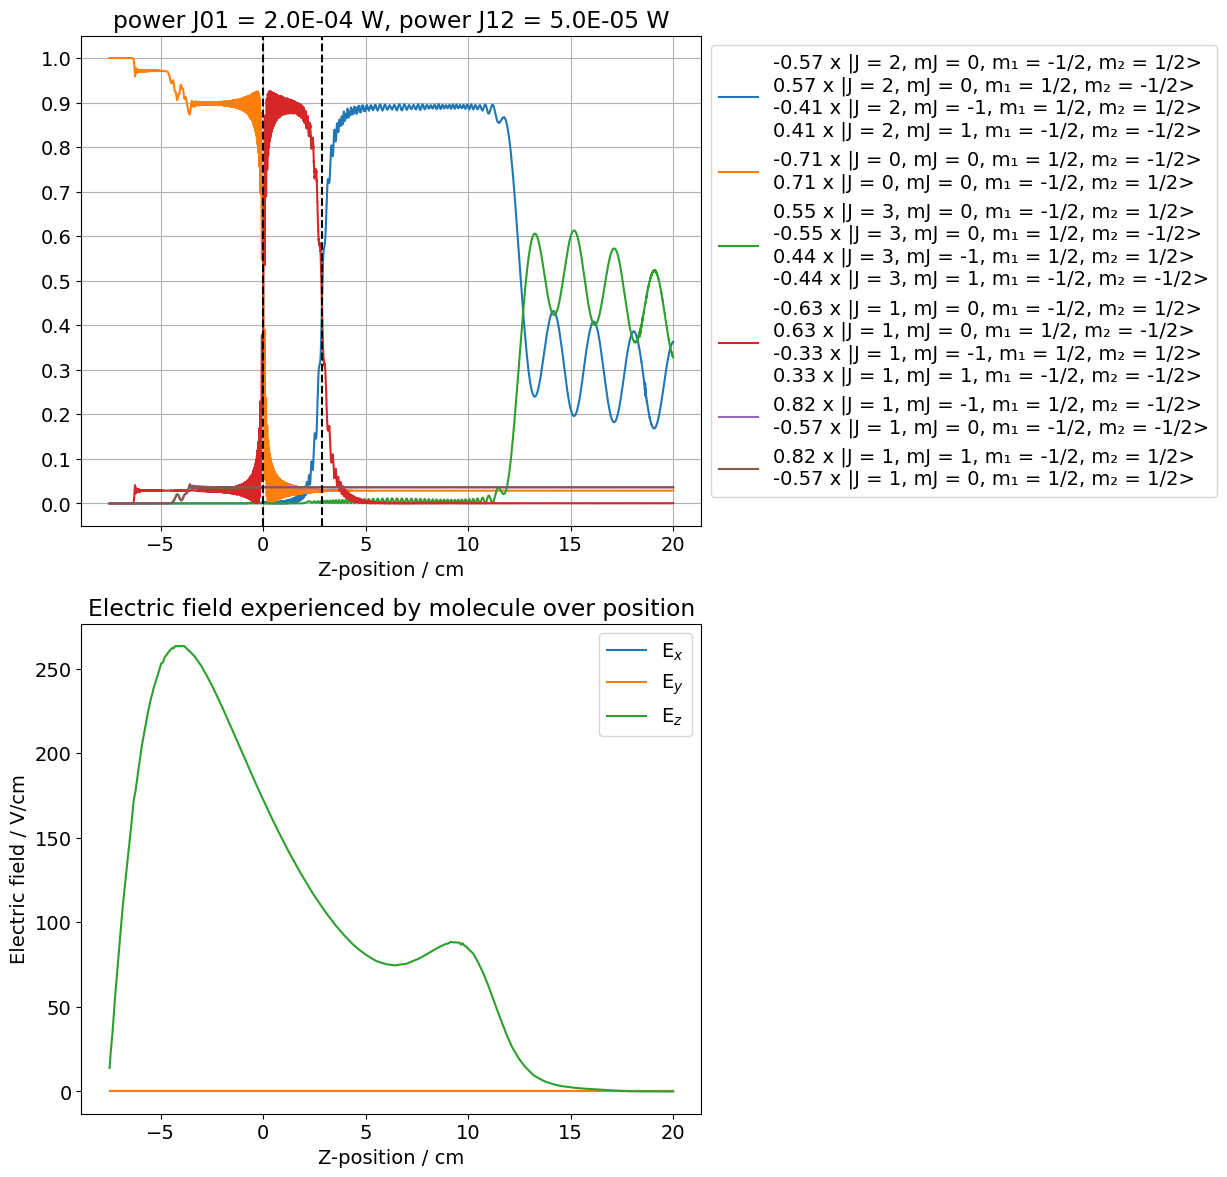

In [34]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=6)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 14))
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.legend(fontsize=14, bbox_to_anchor=(1.0, 1))
ax.axvline(x=pos_J01.value[2] * 1e2, ls="--", c="k")
ax.axvline(x=pos_J12.value[2] * 1e2, ls="--", c="k")
ax.set_title(
    f"power J01 = {mf01.intensity.power:.1E} W, power J12 = {mf12.intensity.power:.1E} W"
)
ax.grid()

_ = electric_field.plot(trajectory, position=True, ax=ax2)


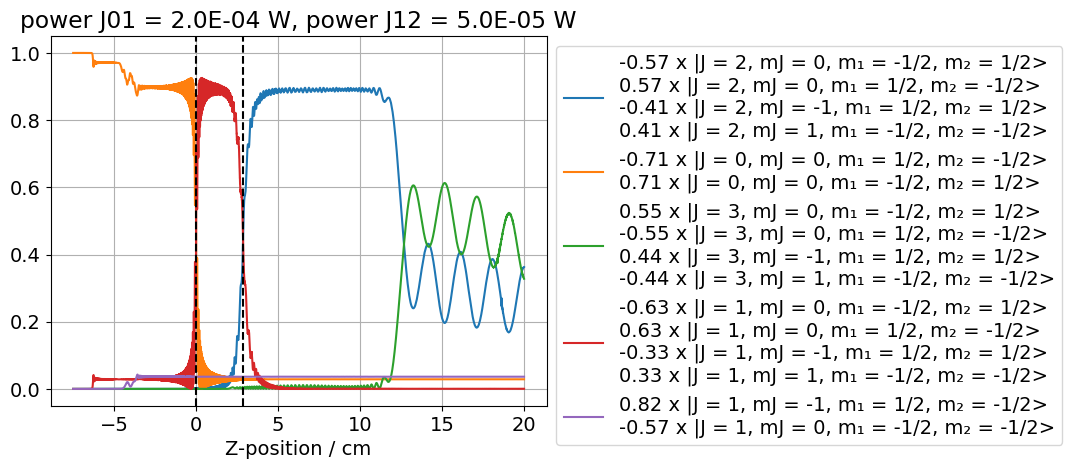

In [35]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=5)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.legend(fontsize=14, bbox_to_anchor=(1.0, 1))
ax.axvline(x=pos_J01.value[2] * 1e2, ls="--", c="k")
ax.axvline(x=pos_J12.value[2] * 1e2, ls="--", c="k")
ax.set_title(
    f"power J01 = {mf01.intensity.power:.1E} W, power J12 = {mf12.intensity.power:.1E} W"
)
ax.grid()
